In [ ]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(abind)
library(fields)

In [63]:
trunc <-
    function(x, ..., prec = 1)
      base::trunc(x * 10 ^ prec, ...) / 10 ^ prec
  
  
  flat <- function(x) {
    return(paste0(trunc(c(x), prec = 4), collapse = ","))
  }

normalized <- function(x) {
        (x - min(x)) / (max(x) - min(x))
      }

### Read processed files and create big matrix with all rows

In [130]:
setwd("~/Downloads/data/")
system("find . -type f -name \"*.log\" -print0 | xargs -0 cat > ALL.data")
df_all <- data.frame(fread("ALL.data", sep=",", header = F), stringsAsFactors=F)
dim(df_all)
df_all <- df_all[complete.cases(df_all),]
dim(df_all)

[1] 18004  1626

[1] 18004  1626

### Experiment parameters

In [131]:
# Resolution for target frequency [0-100]
input_resolution <- 0.25
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

classses <- seq(
    from = 0.0,
    to = 14 / 0.0864,
    by = output_resolution
  )

# Output dimension
num_classes <-
  length(classses) # Buckets of possible classes

print("Output classes (Dnu or dr): ")
classses
print(num_classes)

[1] "Output classes (Dnu or dr): "


[1]   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
 [19]  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
 [37]  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
 [55]  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
 [73]  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 [91]  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
[109] 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
[127] 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
[145] 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
[163] 162

[1] 163


### Matrix creation from data

In [132]:
# Dataset shape
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 4

# Number of channels
dimensions <- 4
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)
ind_data <- seq(from=1,to=rows)

In [133]:
# Reshape dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:406])
X[ind_data, , 2] <- as.matrix(df_all[ind_data, 406:((406 * 2) - 1)]) 
X[ind_data, , 3] <- as.matrix(df_all[ind_data, (406 * 2):((406 * 3) - 1)])
X[ind_data, , 4] <- as.matrix(df_all[ind_data, (406 * 3):((406 * 4) - 1)]) / 0.0864
Y <- to_categorical(df_all[ind_data, 1626:1626] / 0.0864 , num_classes)

In [68]:
for (i in ind_data){
    X[i, , 1] <- normalized(t(X[i, , 1]))
}
for (i in ind_data){
    X[i, , 2] <- normalized(t(X[i, , 2]))
}

for (i in ind_data){
    X[i, , 3] <- normalized(t(X[i, , 3]))
}

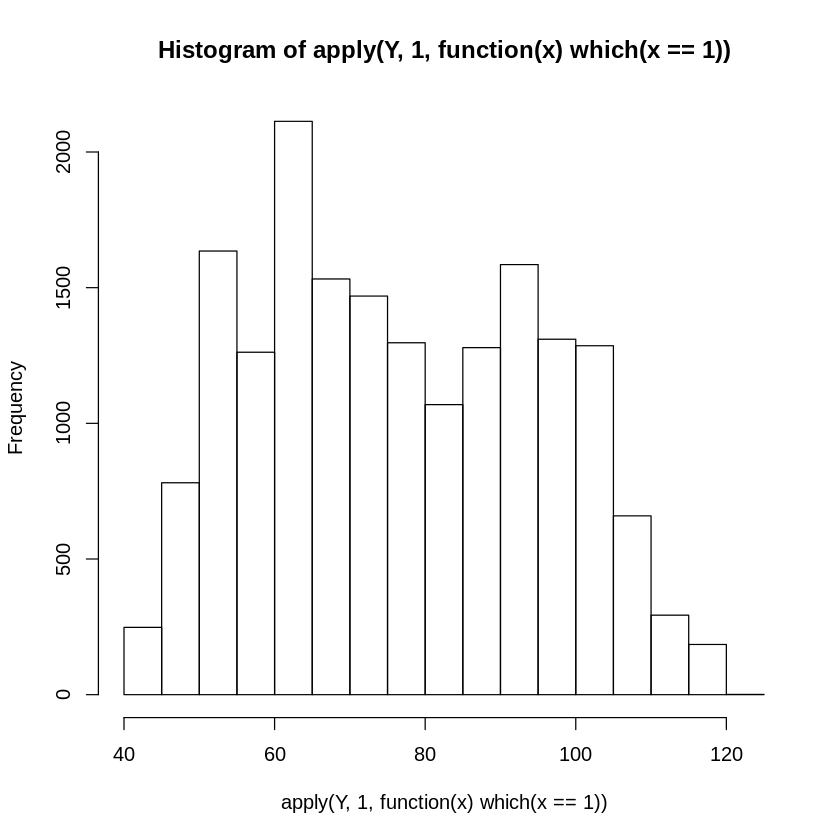

In [134]:
hist(apply(Y,1,function(x) which(x==1)))

### Check that target is not in the trainind data

In [81]:
print(paste0("Check for target 1:"))
flags <- c()
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1626:1626] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

flags <- c()
print(paste0("Check for target 2:"))
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1625:1625] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

[1] "Check for target 1:"
flags
FALSE  TRUE 
11890     1 
[1] "Check for target 2:"
flags
FALSE  TRUE 
11881    10 


In [82]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [83]:
# Split train/test
smp_size <- floor(0.9 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 10701   406     4

[1] 10701   139

[1] 1190  406    4

[1] 1190  139

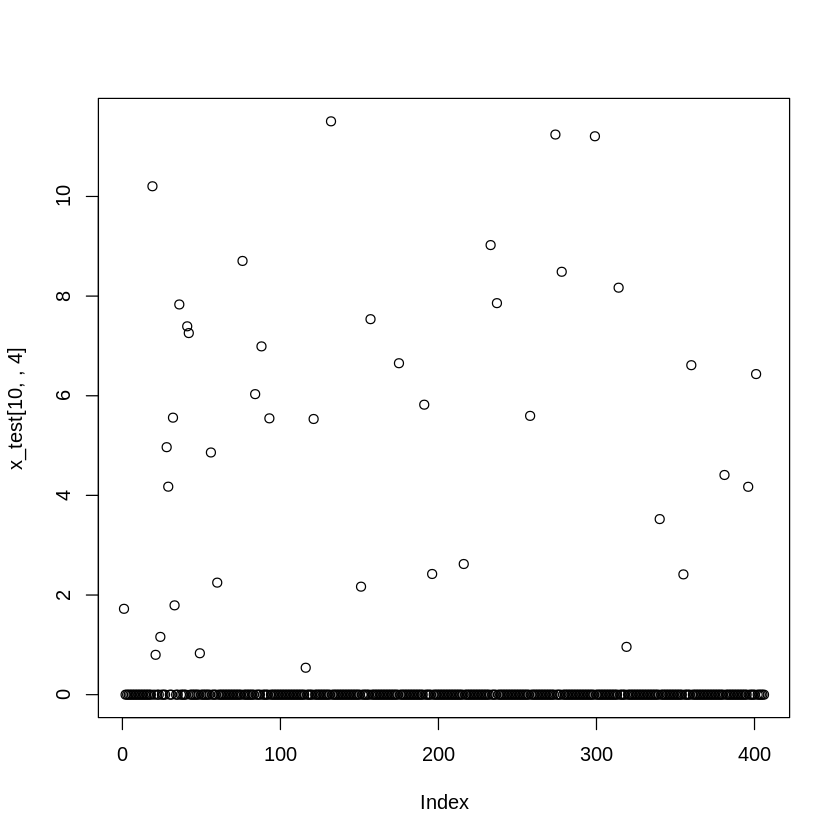

In [84]:
plot(x_test[10,,4])

### Calculate class weigth

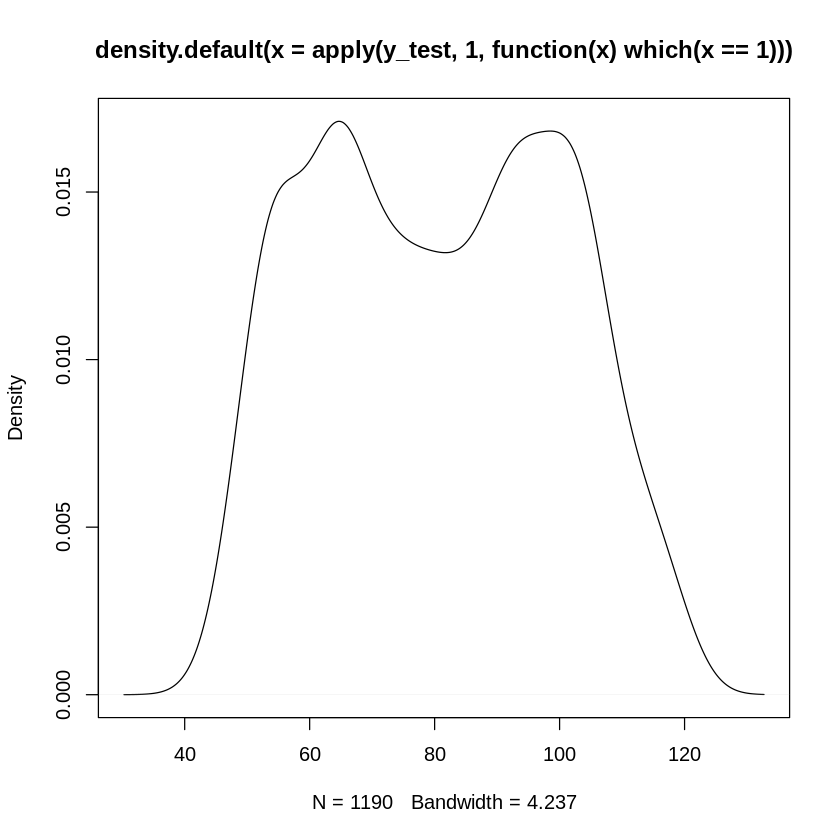

In [85]:
den <- density(apply(y_test,1,function(x) which(x==1)))
plot(den)

[1]   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
 [19]  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
 [37]  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
 [55]  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
 [73]  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 [91]  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
[109] 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
[127] 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
[145] 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
[163] 162

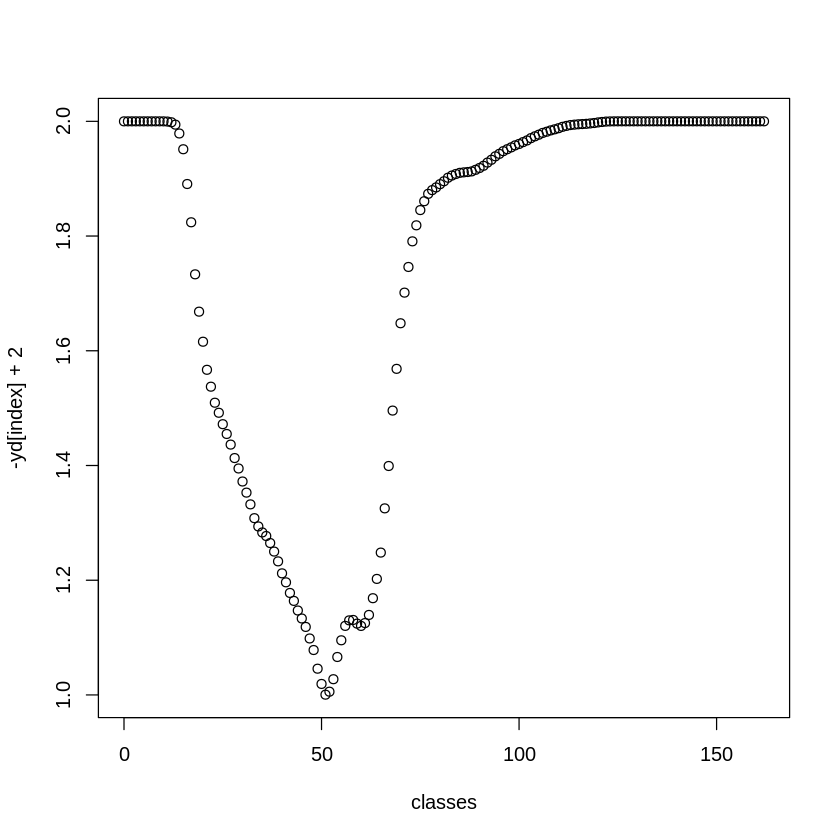

In [328]:
#classes <- seq(
#    from = 0.0,
#    to = 14 / 0.0864,
#    by = output_resolution)
#classes
    

#yd <- normalized(as.numeric(den$y))
#index <- as.numeric(lapply(classes,function(x) which.min(abs(x-den$x))))

                           
#plot(classes, -yd[index]+2)
#weight_classes <- -yd[index]+2

### NN train

In [86]:
top_8_categorical_accuracy <-
  custom_metric("rec_at_8", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 8)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })

In [87]:
checkpoint_dir <- "~/Downloads/test/"
if (T) {
    unlink(checkpoint_dir, recursive = TRUE)
    dir.create(checkpoint_dir)
    filepath <- file.path(checkpoint_dir, "weights.{epoch:02d}-{val_loss:.2f}.hdf5")


# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = filepath,
  save_weights_only = TRUE,
  period = 5,
  verbose = 1
)
}

# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(406,4)
  ) %>%
  layer_max_pooling_1d(pool_size = 4) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_8_categorical_accuracy
        )
)
summary(model) # Plot summary

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_10 (SeparableConv1 (None, 403, 8)                  488         
________________________________________________________________________________
max_pooling1d_10 (MaxPooling1D)     (None, 100, 8)                  0           
________________________________________________________________________________
dropout_10 (Dropout)                (None, 100, 8)                  0           
________________________________________________________________________________
batch_normalization_10 (BatchNormal (None, 100, 8)                  32          
________________________________________________________________________________
flatten_8 (Flatten)                 (None, 800)                     0           
________________________________________________________________________________
dense_8 (Dense)             

In [88]:
if (T) {
# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 700,
    batch_size =  250,
    validation_split = 0.1,
    shuffle = T,
    verbose = 2,
    callbacks = list(cp_callback) 
  )
}

In [89]:
#model %>% load_model_weights_hdf5(
#  file.path("~/Downloads/checkpointsDnuData2/weights.390-2.26.hdf5")
#)
evaluate(model, x_test, y_test)

# evaluate on delta scuti stars
#load("../../docs/GPU/X_scuti.rda")
#load("../../docs/GPU/Y_scuti.rda")
#evaluate(model, X_scuti, Y_scuti)

$loss
[1] 2.687565

$acc
[1] 0.2857143

$rec_at_2
[1] 0.4436975

$rec_at_4
[1] 0.5857143

$recat_6
[1] 0.6781513

$rec_at_8
[1] 0.7252101

In [43]:
plot(history) +
  theme_bw()

ERROR: Error in .External2(C_savehistory, file): no history available to save


### Confusion matrix

In [90]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)
# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
dtCM$c1 <- as.numeric(dtCM$c1)
dtCM$c2 <- as.numeric(dtCM$c2)
dtCM$freq <- as.numeric(dtCM$freq)
dim(dtCM)

[1] 5624    3

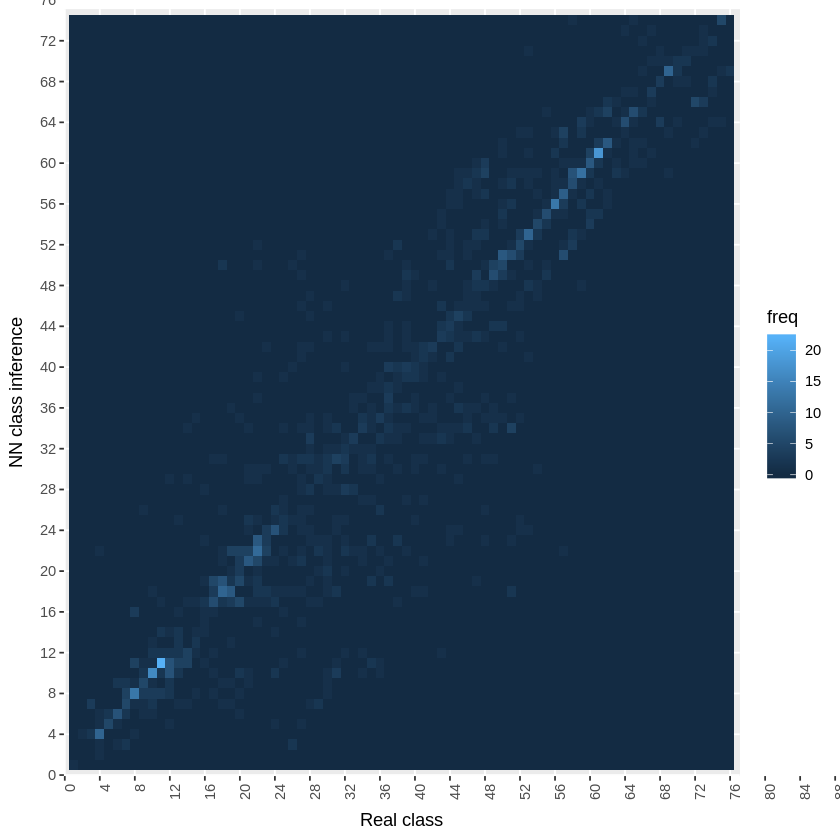

In [91]:
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_tile() +
  #scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  #scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2))
  scale_x_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) +
  scale_y_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120))  +
  xlab("Real class") +
  ylab("NN class inference")

### MSE error acc_at_1

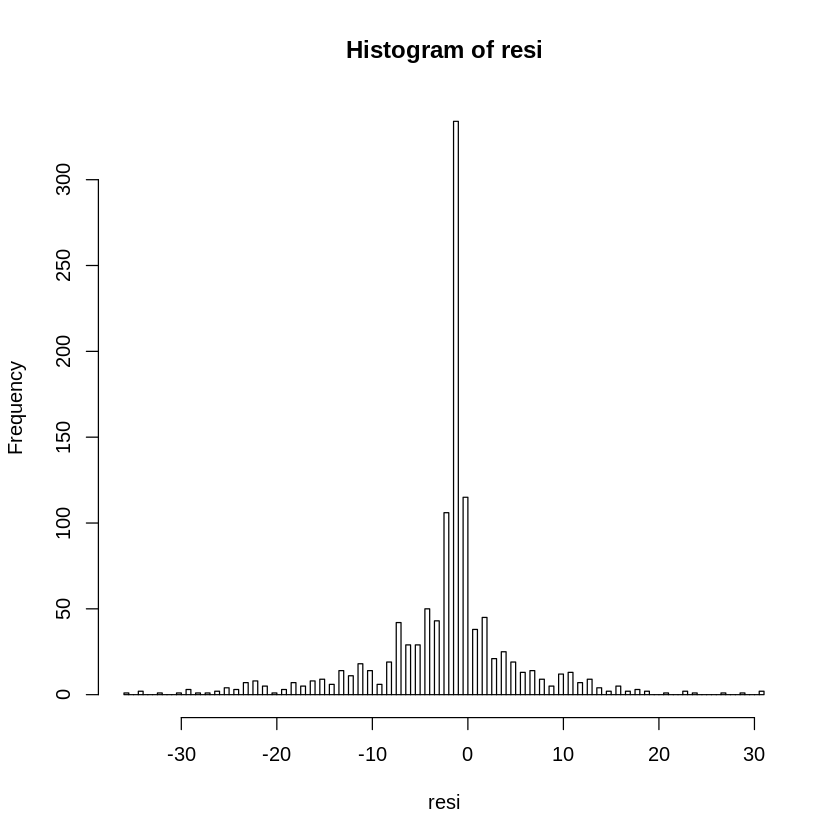


FALSE  TRUE 
  176   988 


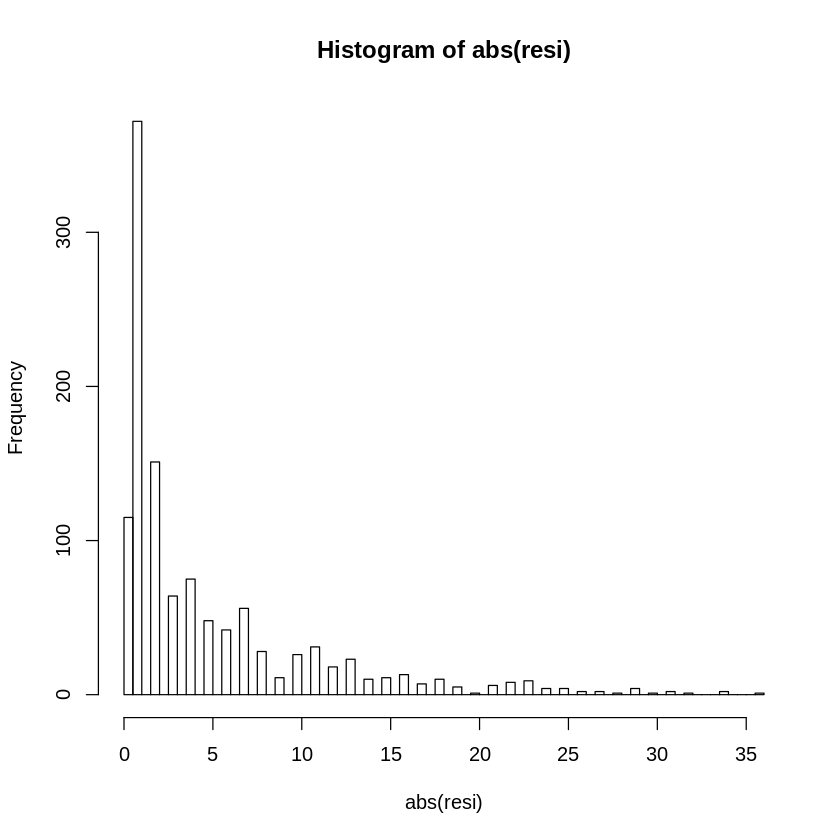

In [92]:
# Output dimension
classes <- seq(
    from = 0.1,
    to = 10 / 0.0864,
    by = output_resolution
  )


resi <- ((classes[Y_test_hat]) - (classes[apply(y_test,1,function(x) which(x==1))]))
hist(resi, breaks=100)
hist(abs(resi), breaks=100)
print(table(abs(resi)<=10))

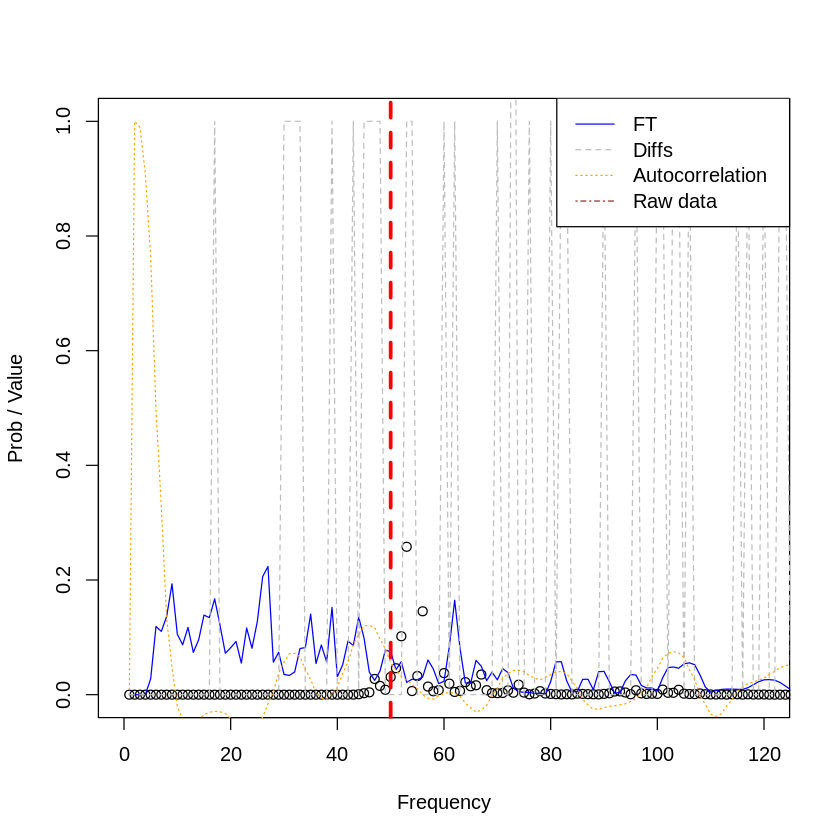

In [94]:
select_test <- 100

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)


lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")
#lines(x_test[select_test, , 4], lty = 3, col = "brown")

abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)


legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation", "Raw data"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange", "brown")
)

### Auxiliar functions for Validation on $\delta$-scuti stars

In [97]:
validate_real_star <- function(data, real_dnu, real_dr, numFrequencies=30) {


    
  # Execute experiment
  result <- process(
    frequency = data$V1,
    amplitude = data$V2,
    filter = "uniform",
    gRegimen = 0,
    maxDnu = 1,
    minDnu = 15,
    numFrequencies = numFrequencies,
    dnuGuessError = -1,
    debug = F,
    processFirstRangeOnly = numFrequencies
  )
  
  
    # Save ft of diffs
  ftS <-
    stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv),
              as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b),
              breaks = cuts_breaks)$stats
  ft_1D <- ftS[8, 1:(length(cuts_breaks) - 1)]
  ft_1D[is.na(ft_1D)] <- 0

    diffS <-
      stats.bin(
        as.numeric(result$diffHistogram$histogram$bins),
        as.numeric(result$diffHistogram$histogram$values),
        breaks = cuts_breaks
      )$stats
    diff_2D <- diffS[8, 1:(length(cuts_breaks) - 1)]
    diff_2D[is.na(diff_2D)] <- 0
    
    # Save crosscorrelation
    cross <- stats.bin(
      as.numeric(result$crossCorrelation$index),
      as.numeric(result$crossCorrelation$autocorre),
      breaks = cuts_breaks
    )$stats
    cross_3D <- cross[8, 1:(length(cuts_breaks) - 1)]
    cross_3D[is.na(cross_3D)] <- 0
          
    # Raw information
    rawS <-
      stats.bin(as.numeric(data$V1)/0.0864,
                as.numeric(data$V2),
                breaks = cuts_breaks)$stats
    raw_1D <- rawS[8, 1:(length(cuts_breaks) - 1)]
    raw_1D[is.na(raw_1D)] <- 0
    
    # Assert all dimensions are equal
    stopifnot((length(ft_1D) == length(diff_2D)) ==
                ((length(diff_2D) == length(cross_3D)) ==
                   (
                     length(cross_3D) == length(cuts_breaks) - 1
                   )))
    

  rows <- dim(df_all)[1]
  dimensions <- 4 # Number of channels
  cols <- (dim(df_all)[2] - 2) / 4
  X <- array(0, c(1, cols, dimensions))
  # Y train is a 1D matrix with rows and targets
  Y <- matrix(0, nrow = 1, ncol = num_classes)
  ind_data <- seq(from = 1, to = rows)
    
    
  X[1, , 1] <- ft_1D
  X[1, , 2] <- diff_2D
  X[1, , 3] <- cross_3D
  X[1, , 4] <- raw_1D 

  print(paste0("Max hist diff:",max(X[1, , 2])))
  print(paste0("Mas acutocorre:",max(X[1, , 3])))
  #print(paste0("Max raw:",max(X[1, , 4])))


  plot(
    seq(
    from = 0.0,
    to = 12 / 0.0864,
    by = 1),
    t(predict(modelDnu, X)),
    lty = 1,
    pch = 2,
    ylim = c(0, 1),
    xlim = c(0, 100),
    col = "black",
    xlab = "Frequency",
    ylab = "Prob / Value"
   )
    
  
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 1]), lty = 1, col = alpha("blue", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 2]), lty = 1, col = alpha("grey", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 3]), lty = 1, col = alpha("orange", 0.4))
  #lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 4]), lty = 1, col = alpha("brown", 0.4))

  abline(
   v = real_dnu,
   col = "red",
   lwd = 3,
   lty = 2
  )
    
abline(
   v = real_dr,
   col = "blue",
   lwd = 3,
   lty = 2
  )
    
  legend(
    "topright",
    c("FT", "Diffs", "Autocorrelation", "Raw", "NN-Dnu", "NN-dr"),
    lty = c(1, 2, 3, 4,NA,NA),
    pch = c(NA,NA,NA,NA,2,3),
    col = c("blue", "grey", "orange", "brown", "black", "black")
  )
    
    return(as.numeric(which.max(t(predict(modelDnu, X)))))
}



# Validation on $\delta$-scuti stars

In [98]:
#Read models
# Create a 1d convolutional NN
modelDnu <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(406,4)
  ) %>%
  layer_max_pooling_1d(pool_size = 4) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')

modelDnu %>% load_model_weights_hdf5(
  file.path("~/Downloads/test/weights.255-2.71.hdf5")
)




# Read file stars
stars_base_dir <- "~/Projects/variableStars/data/deltaScuti/"
setwd(stars_base_dir)
for (file in list.files()) {
    print(file)
    #data <- read.csv(file, sep="", header=F)
    #validate_real_star(data)
}
errors <- data.frame(matrix(ncol=3, nrow=0))
colnames(errors) <- c("star", "difference", "n")
#errors

[1] "CID100866999.lis"
[1] "CID105906206.lis"
[1] "HD15082.lis"
[1] "HD159561.lis"
[1] "HD172189.lis"
[1] "KIC10080943.lis"
[1] "kic10661783.lis"
[1] "KIC3858884.lis"
[1] "kic4544587.lis"
[1] "KIC8262223.lis"
[1] "KIC9851944.lis"


## CID100866999.lis

[1] "Nrows: 8"


V1,V2
16.9803,11.623
16.2530,0.508
21.8711,0.449
17.5521,0.223
21.6053,0.167
17.5674,0.151


[1] "Max hist diff:4"
[1] "Mas acutocorre:1"
[1] 104


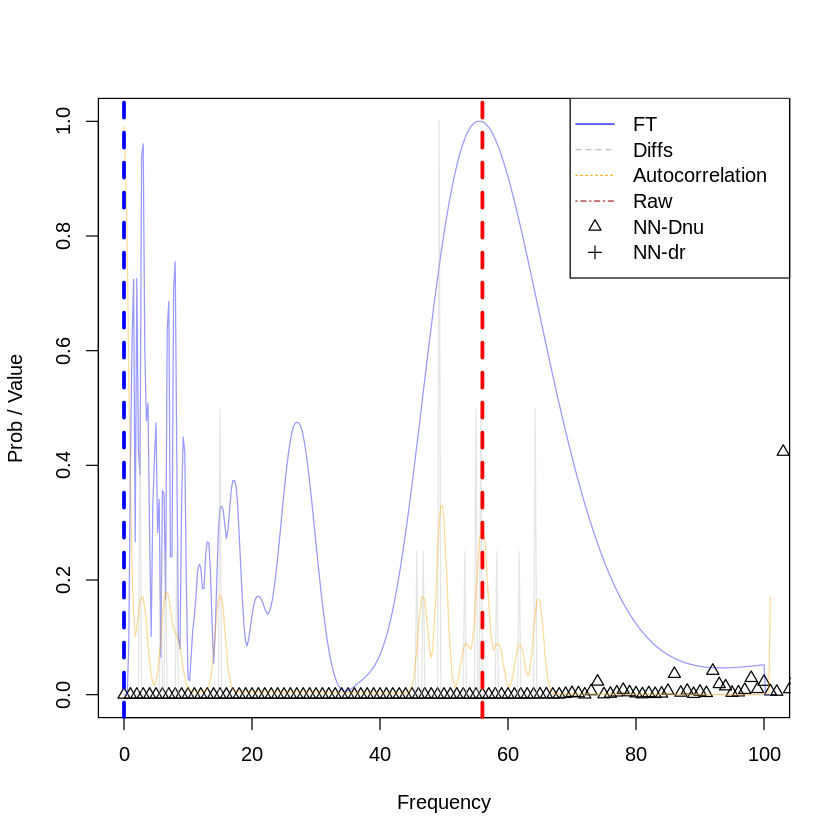

In [99]:
# Quitar las frecuencias < 5 ciclos por día.
d <- read.csv(paste0(stars_base_dir,"CID100866999.lis"), sep="", header=F)
print(paste0("Nrows: ", dim(d)[1]))
head(d)
max <- validate_real_star(d, 56, 0) # There is no information about dr
print(max)
errors <- rbind(errors, data.frame("star"="CID100866999", "difference"=56-max, "n"=dim(d)[1]))

## CID105906206.lis

V1,V2
9.4175,2.552
9.0696,2.296
10.7776,2.150
5.6119,1.160
8.9203,0.906
0.1192,0.880


[1] "Nrows: 202"
[1] "Max hist diff:7"
[1] "Mas acutocorre:1"


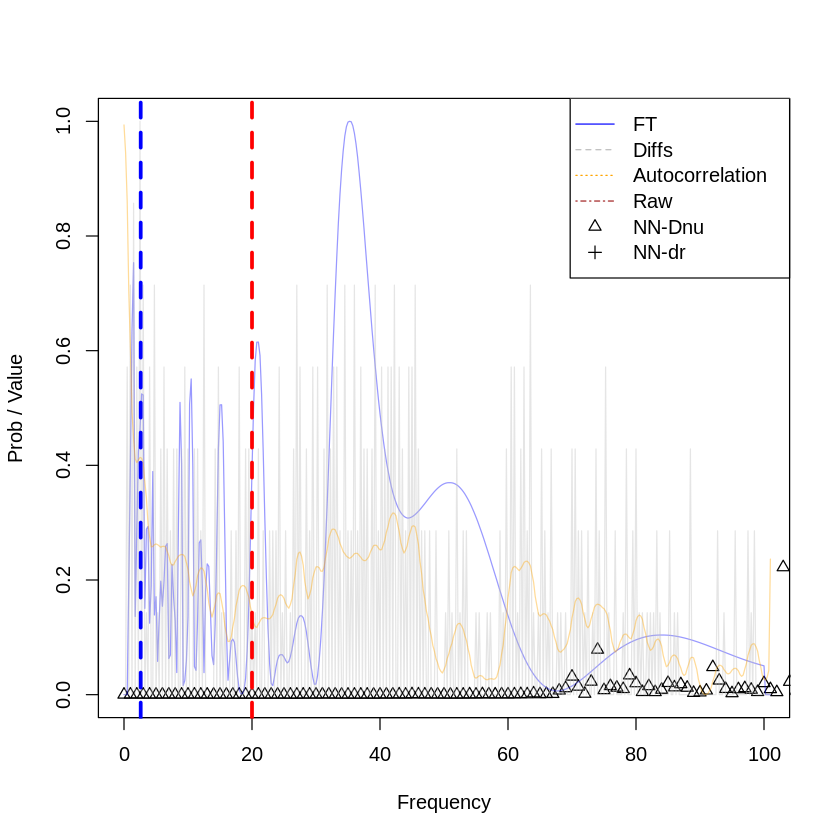

In [100]:
d <- read.csv(paste0(stars_base_dir,"CID105906206.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 20, 2.61)
errors <- rbind(errors, data.frame("star"="CID105906206", "difference"=20-max, "n"=dim(d)[1]))

## HD15082.lis

V1,V2
20.163899,0.05826439
9.842703,0.05056994
21.064683,0.04185181
1.901497,0.04169184
14.207774,0.04024543
1.028524,5.41987344


[1] "Nrows: 71"
[1] "Max hist diff:6"
[1] "Mas acutocorre:1"


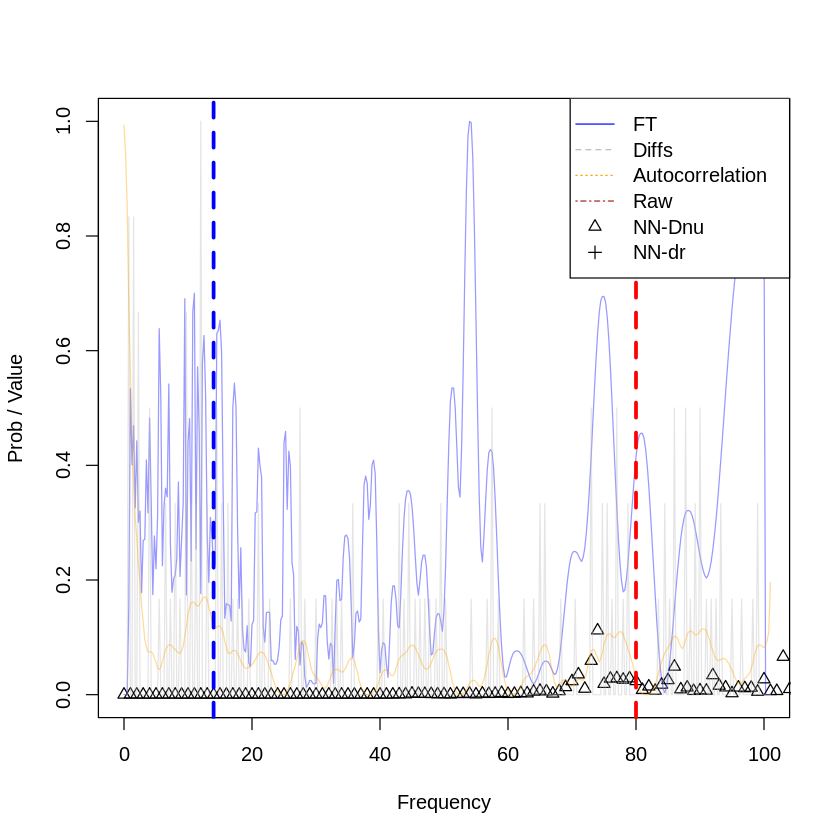

In [101]:
d <- read.csv(paste0(stars_base_dir,"HD15082.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 80, 14)
errors <- rbind(errors, data.frame("star"="HD15082", "difference"=80-max, "n"=dim(d)[1]))

## HD159561.lis

V1,V2
10.227,0.091
10.469,0.104
10.619,0.243
11.720,0.405
13.096,0.144
16.124,0.349


[1] "Nrows: 40"
[1] "Max hist diff:2"
[1] "Mas acutocorre:1"


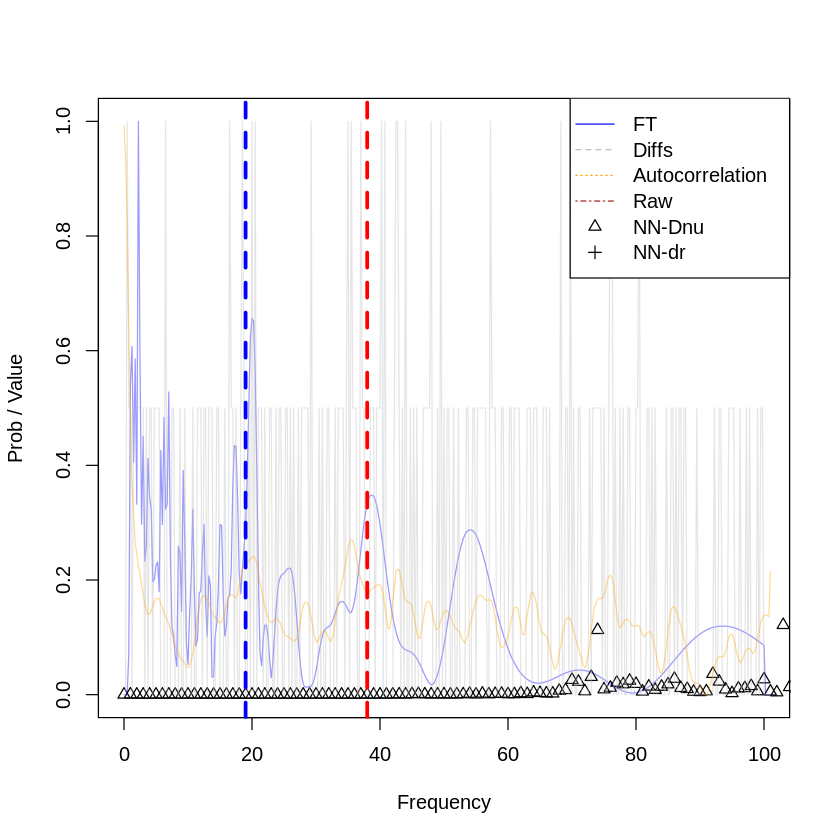

In [102]:
d <- read.csv(paste0(stars_base_dir,"HD159561.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 38, 19)
errors <- rbind(errors, data.frame("star"="HD159561", "difference"=38-max, "n"=dim(d)[1]))

## HD172189.lis

V1,V2
19.58317,4.513889e-05
17.32212,7.523148e-05
17.94392,7.754630e-05
17.84847,7.986111e-05
19.47873,8.333333e-05
18.02352,1.053241e-04


[1] "Nrows: 50"
[1] "Max hist diff:3"
[1] "Mas acutocorre:1"


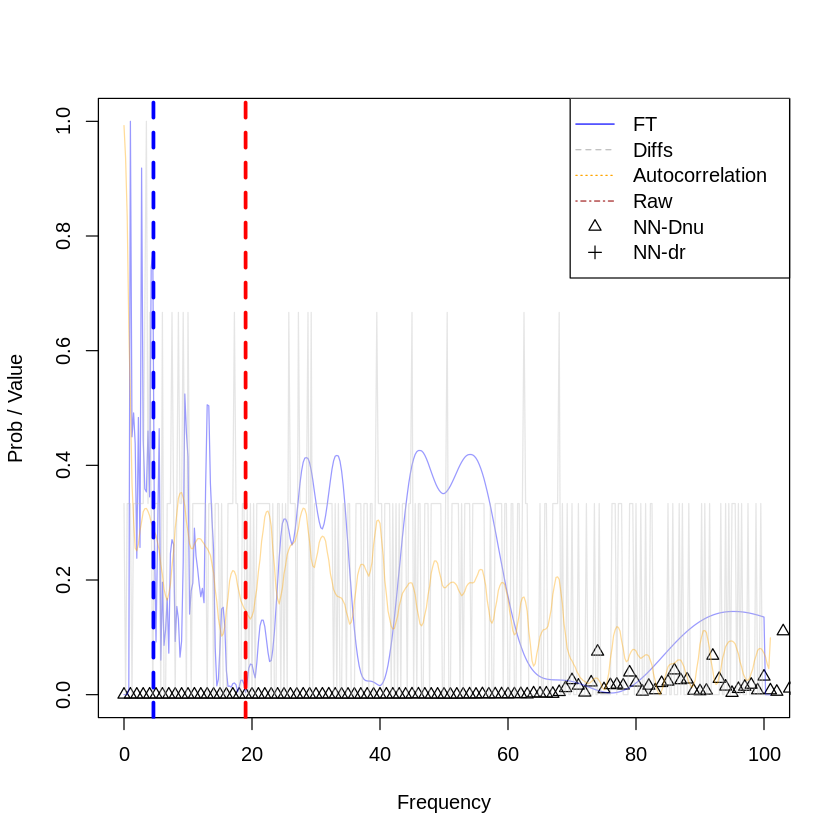

In [103]:
d <- read.csv(paste0(stars_base_dir,"HD172189.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))


max <- validate_real_star(d, 19, 4.6)
errors <- rbind(errors, data.frame("star"="HD172189", "difference"=19-max, "n"=dim(d)[1]))

## KIC10080943.lis

V1,V2
13.94759,1360.9
3.33350,1321.8
15.68333,1241.7
12.45258,931.5
12.89054,758.4
17.30504,616.1


[1] "Nrows: 321"
[1] "Max hist diff:2"
[1] "Mas acutocorre:1"


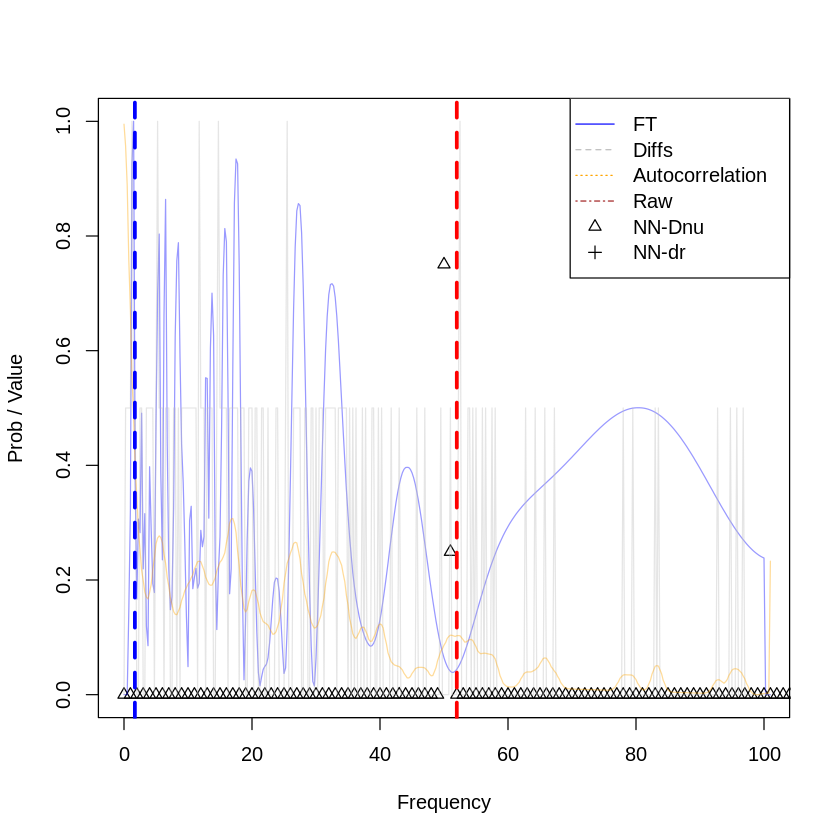

In [104]:
d <- read.csv(paste0(stars_base_dir,"KIC10080943.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 52, 1.7)
errors <- rbind(errors, data.frame("star"="KIC10080943", "difference"=52-max, "n"=dim(d)[1]))

## kic10661783.lis

V1,V2
28.134,3.07
22.338,3.56
29.383,2.67
25.902,2.02
27.810,0.91
24.407,2.34


[1] "Nrows: 12"
[1] "Max hist diff:1"
[1] "Mas acutocorre:1"


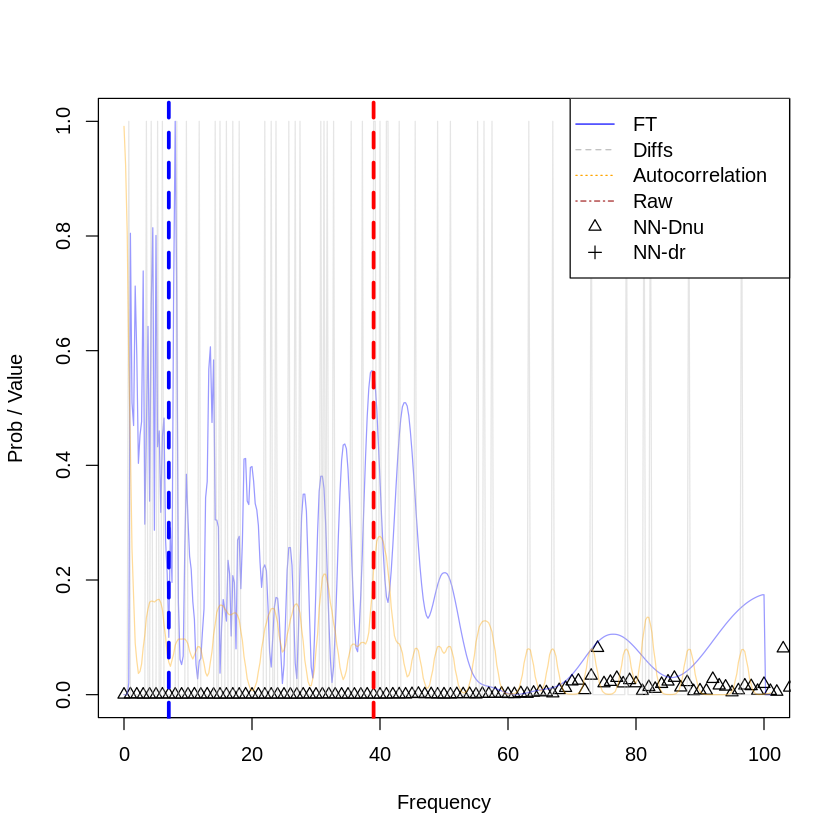

In [105]:
d <- read.csv(paste0(stars_base_dir,"kic10661783.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 39, 7)
errors <- rbind(errors, data.frame("star"="kic10661783", "difference"=39-max, "n"=dim(d)[1]))

## KIC3858884.lis

V1,V2
7.2306,10.15
7.4734,9.10
9.8376,1.96
7.5125,1.75
6.7358,1.55
9.5191,1.24


[1] "Nrows: 400"
[1] "Max hist diff:14"
[1] "Mas acutocorre:1"


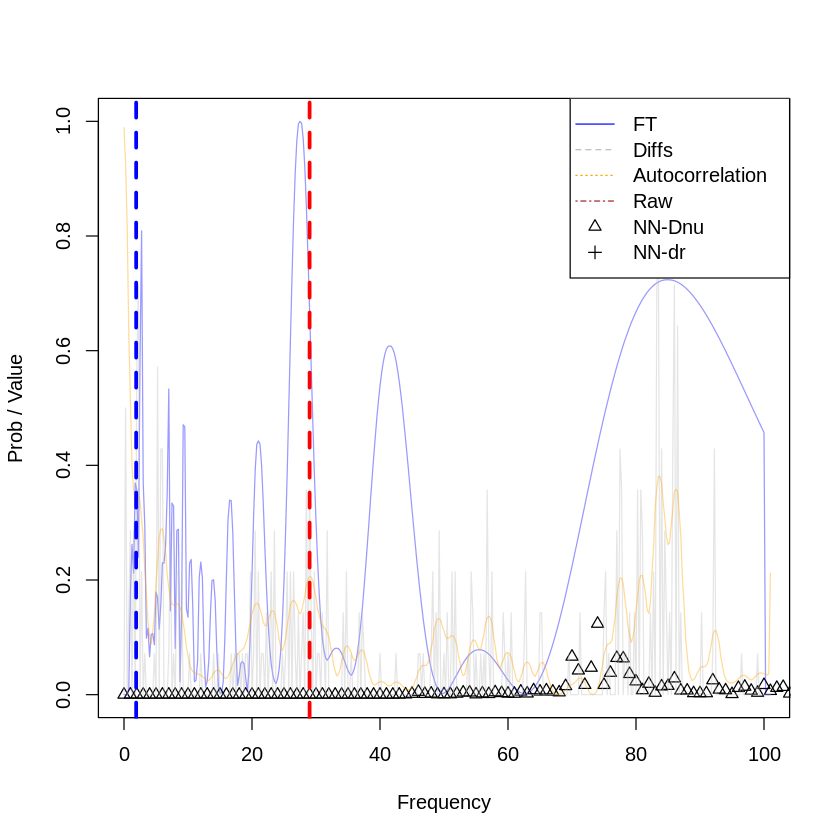

In [106]:
d <- read.csv(paste0(stars_base_dir,"KIC3858884.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 29, 1.9)
errors <- rbind(errors, data.frame("star"="KIC3858884", "difference"=29-max, "n"=dim(d)[1]))

## kic4544587.lis

V1,V2
48.02231,0.329
41.37020,0.236
44.84695,0.181
46.19662,0.152
48.04449,0.122
39.54280,0.106


[1] "Nrows: 16"
[1] "Max hist diff:5"
[1] "Mas acutocorre:1"


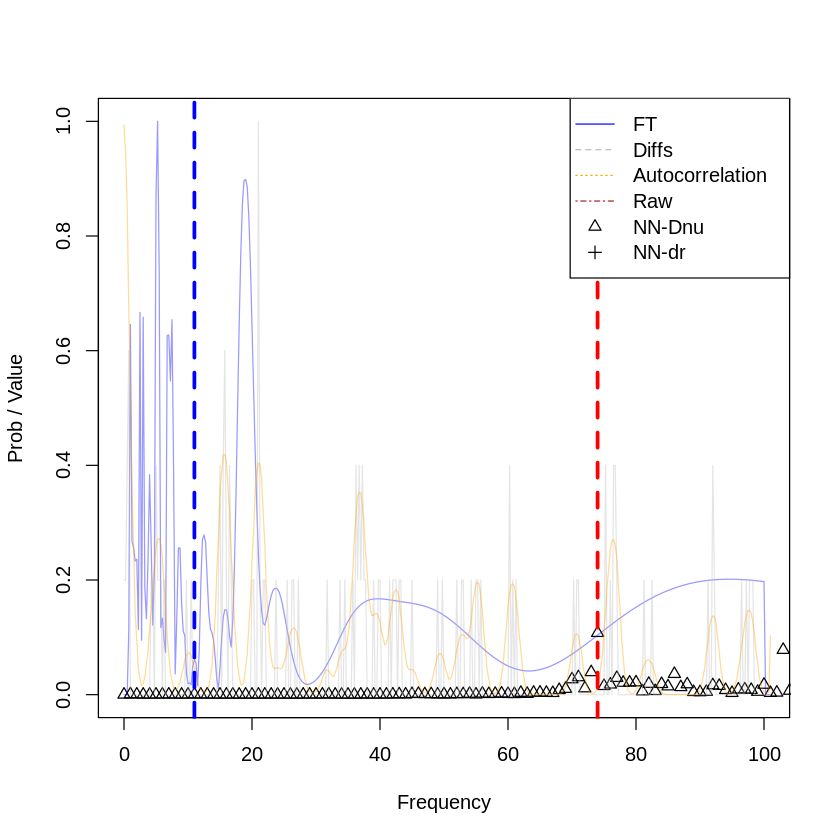

In [107]:
d <- read.csv(paste0(stars_base_dir,"kic4544587.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 74, 11)
errors <- rbind(errors, data.frame("star"="kic4544587", "difference"=74-max, "n"=dim(d)[1]))

## KIC8262223.lis

V1,V2
64.43390,1.319
57.17794,0.918
61.43616,0.782
53.64792,0.620
51.04548,0.565
54.78183,0.540


[1] "Nrows: 60"
[1] "Max hist diff:7"
[1] "Mas acutocorre:1"


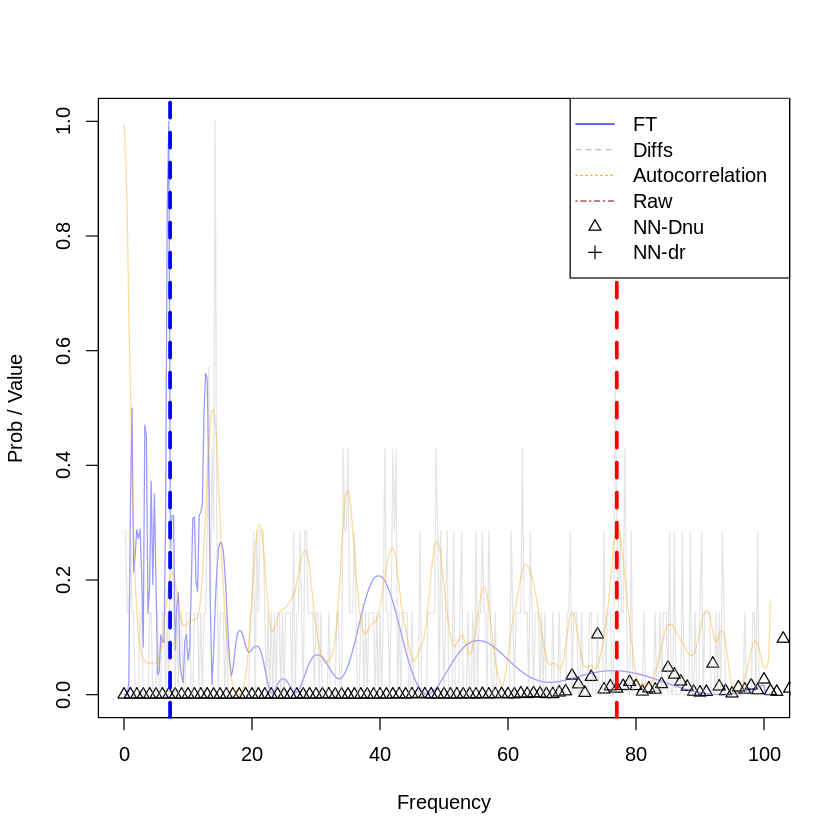

In [108]:
d <- read.csv(paste0(stars_base_dir,"KIC8262223.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 77, 7.2)
errors <- rbind(errors, data.frame("star"="KIC8262223", "difference"=77-max, "n"=dim(d)[1]))

## KIC9851944.lis

V1,V2
10.399692,0.6530
10.176019,0.5480
11.890476,0.4540
5.097099,0.4046
11.018543,0.2290
12.814916,0.2232


[1] "Nrows: 52"
[1] "Max hist diff:5"
[1] "Mas acutocorre:1"


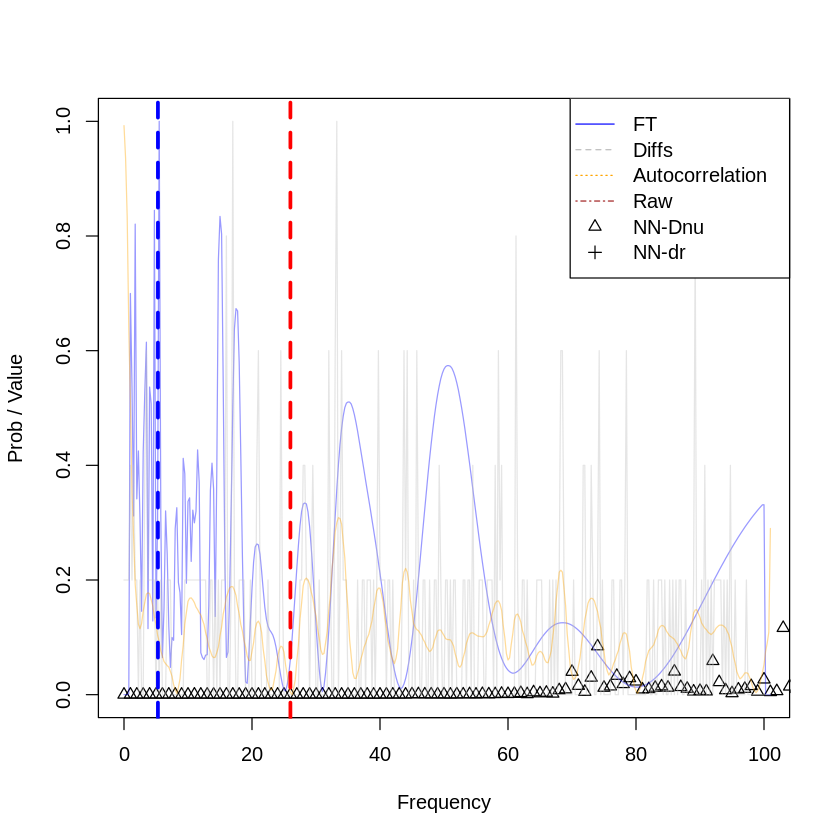

In [109]:
d <- read.csv(paste0(stars_base_dir,"KIC9851944.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 26, 5.3)
errors <- rbind(errors, data.frame("star"="KIC9851944", "difference"=26-max, "n"=dim(d)[1]))

## All errors

In [110]:
errors
mean(errors$difference)
mean((errors$difference)^2)

star,difference,n
CID100866999,-48,8
CID105906206,-84,202
HD15082,5,71
HD159561,-66,40
HD172189,-85,50
KIC10080943,1,321
kic10661783,-36,12
KIC3858884,-46,400
kic4544587,-1,16
KIC8262223,2,60


[1] -39.63636

[1] 2769.818

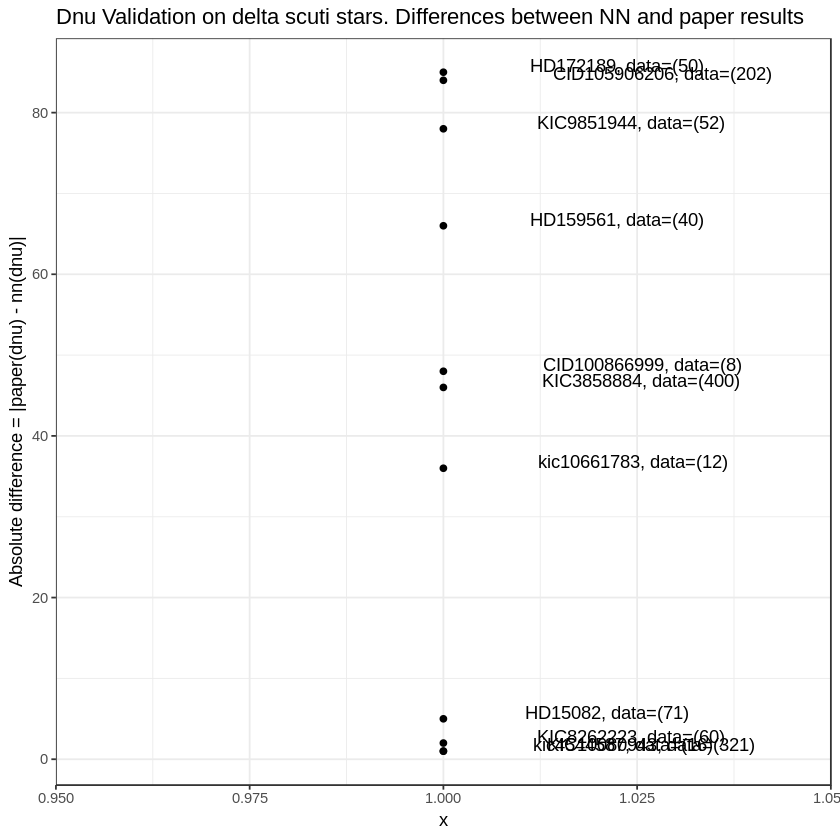

In [111]:
ggplot(aes(y=abs(difference), x=1), data=errors) +
    geom_point() +
    geom_text(aes(label=paste0(star,", data=(",n,")")),hjust=-0.5, vjust=0) +
    ggtitle("Dnu Validation on delta scuti stars. Differences between NN and paper results") +
    ylab("Absolute difference = |paper(dnu) - nn(dnu)|") +
    theme_bw()

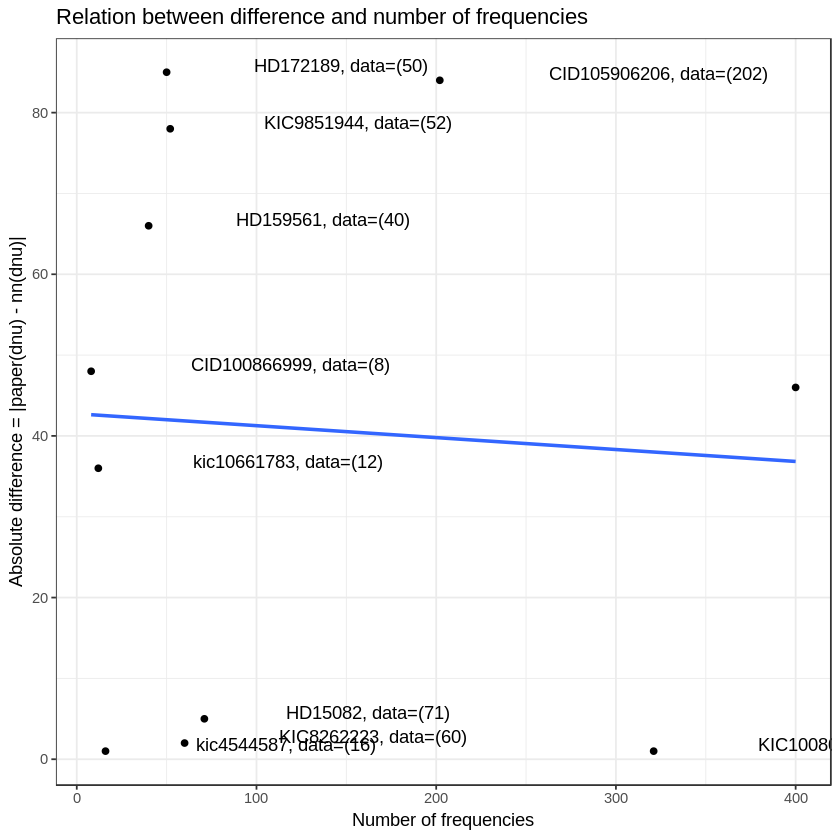

In [112]:
ggplot(aes(y=abs(difference), x=n), data=errors) +
    geom_point()  +
     stat_smooth(method="lm", se=F) +
     geom_text(aes(label=paste0(star,", data=(",n,")")),hjust=-0.5, vjust=0) +
     ggtitle("Relation between difference and number of frequencies") +
     ylab("Absolute difference = |paper(dnu) - nn(dnu)|") +
     xlab("Number of frequencies") +
     theme_bw()